In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
url = 'drive/MyDrive/a/'
# url = ''

# Preprocessing

## Importing Libraries

In [3]:
!pip install hazm

In [4]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import re
from hazm import InformalNormalizer, Normalizer, word_tokenize
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

## preprocessing prepared data (taghche.csv)

In [5]:
tqdm.pandas()

In [6]:
prepared_data: pd.DataFrame = pd.read_csv(url + 'datasets/taghche.csv')
prepared_data = prepared_data[['comment', 'bookname', 'bookID']]

In [7]:
prepared_data.head()

comment  \
0  اسم کتاب   No one writes to the Colonel\nترجمش...   
1  طاقچه عزیز،نام کتاب"کسی به سرهنگ نامه نمینویسد...   
2  بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...   
3  به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...   
4                                      کتاب خوبی است   

                            bookname  bookID  
0  سرهنگ کسی ندارد برایش نامه بنویسد     3.0  
1  سرهنگ کسی ندارد برایش نامه بنویسد     3.0  
2  سرهنگ کسی ندارد برایش نامه بنویسد     3.0  
3  سرهنگ کسی ندارد برایش نامه بنویسد     3.0  
4  سرهنگ کسی ندارد برایش نامه بنویسد     3.0

In [8]:
chars_stop_words = ''
with open(url + 'stopwords/chars (without digits).txt', 'r', encoding='utf-8') as file:
    chars_stop_words = ''.join(file.read().splitlines())

chars_stop_words = chars_stop_words.replace('[', '\[')
chars_stop_words = chars_stop_words.replace(']', '\]')
chars_pattern = re.compile(f'[{chars_stop_words}]')
chars_pattern

re.compile(r'[\ufeff!"#()*,-./:\[\]«»،؛؟…$ًٌٍَُِّْءٰٔ﷼]', re.UNICODE)

In [9]:
# https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
emojis_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+")
emojis_pattern

re.compile(r'[😀-🙏🌀-🗿🚀-\U0001f6ff\U0001f1e0-🇿]+', re.UNICODE)

In [10]:
def elementary_preprocess(text):
    global chars_pattern, emojis_pattern

    text = str(text)
    text = chars_pattern.sub(r' ', text)
    text = emojis_pattern.sub(r' ', text)
    return text.translate(str.maketrans('0123456789', '۰۱۲۳۴۵۶۷۸۹'))


def higher_preprocess(text, is_informal=False):
    global normalizer

    text = str(text)

    if is_informal:
        text = informal_normalizer_function(text)
    else:
        text = normalizer.normalize(text)

    text = word_tokenize(text)
    return text


# customizing InformalNormalizer().normalize()
# For seeing differences, you can see InformalNormalizer().normalize() method
def informal_normalizer_function(text):
    global informal_normalizer
    text = str(text)

    informal_normalizer = InformalNormalizer()
    text = Normalizer.normalize(informal_normalizer, text)
    sents = [
        informal_normalizer.word_tokenizer.tokenize(sentence)
        for sentence in informal_normalizer.sent_tokenizer.tokenize(text)
    ]

    normalized = [[informal_normalizer.normalized_word(word)[0] for word in sent] for sent in sents]
    normalized = np.array(normalized, dtype=object)
    return np.hstack(normalized)

In [11]:
normalizer = Normalizer()
informal_normalizer = InformalNormalizer()

In [12]:
for column in prepared_data.columns:
    if column == 'bookID':
        continue

    print(f'Column: {column}')
    prepared_data[column] = prepared_data[column].progress_apply(elementary_preprocess)

Column: comment


  0%|          | 0/69829 [00:00<?, ?it/s]

Column: bookname


  0%|          | 0/69829 [00:00<?, ?it/s]

In [13]:
# When you want to do informal normalization, uncomment following lines
# for column in prepared_data.columns:
#     if column == 'bookID':
#         continue
#
#     progress_bar = tqdm(total=len(prepared_data[column]))
#     prepared_data[column] = prepared_data[column].progress_apply(lambda x: higher_preprocess(x, True))


for column in prepared_data.columns:
    if column == 'bookID':
        continue

    print(f'Column: {column}')
    prepared_data[column] = prepared_data[column].progress_apply(higher_preprocess)

Column: comment


  0%|          | 0/69829 [00:00<?, ?it/s]

Column: bookname


  0%|          | 0/69829 [00:00<?, ?it/s]

In [14]:
# prepared_data.to_csv('datasets/preprocessed/preprocessed_taghche.csv')
# prepared_data = pd.read_csv('datasets/preprocessed/preprocessed_taghche.csv')

In [15]:
before_dropping = len(prepared_data)
prepared_data = prepared_data[prepared_data['comment'].apply(lambda x: len(x)) != 0]
print(f'Dropped {before_dropping - len(prepared_data)} rows with empty comment.')

Dropped 431 rows with empty comment.


In [16]:
before_dropping = len(prepared_data)
prepared_data = prepared_data.dropna(subset=['bookID'])
print(f'Dropped {before_dropping - len(prepared_data)} rows with NaN bookID.')

Dropped 39 rows with NaN bookID.


In [17]:
prepared_data.head()

comment  \
0  [اسم, کتاب, No, one, writes, to, the, Colonel,...   
1  [طاقچه, عزیز, نام, کتاب, کسی, به, سرهنگ, نامه,...   
2  [بنظرم, این, اثر, مارکز, خیلی, از, صد, سال, تن...   
3  [به, نظر, کتاب, خوبی, میومد, اما, من, از, ترجم...   
4                                  [کتاب, خوبی, است]   

                                   bookname  bookID  
0  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]     3.0  
1  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]     3.0  
2  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]     3.0  
3  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]     3.0  
4  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]     3.0

## preprocessing crawled data (books_data_part_*.csv)

In [18]:
ALL_PARTS_LEN = 19
crawled_data: pd.DataFrame = pd.read_csv(url + 'datasets/books data/books_data_part_1.csv')
for i in range(2, ALL_PARTS_LEN + 1):
    crawled_data = pd.concat([crawled_data, pd.read_csv(url + f'datasets/books data/books_data_part_{i}.csv')],
                             ignore_index=True)

In [19]:
# sort authors in order to drop duplicates
new_author_function = lambda x: ' $ '.join(sorted(str(x).split(' $ ')))
crawled_data['author'] = crawled_data['author'].apply(new_author_function)

In [20]:
before_dropping = len(crawled_data)
crawled_data = crawled_data.drop_duplicates()
print(f'Dropped {before_dropping - len(crawled_data)} duplicates.')

Dropped 4 duplicates.


In [21]:
before_dropping = len(crawled_data)
crawled_data = crawled_data.dropna(subset=['id'])
print(f'Dropped {before_dropping - len(crawled_data)} rows with NaN id.')

Dropped 1 rows with NaN id.


In [22]:
new_author_function = lambda x: set(x.split(' $ '))
crawled_data['author'] = crawled_data['author'].apply(new_author_function)

In [23]:
# convert each author to an independent row
# because I want to find each author independently in the comments
crawled_data = crawled_data.explode('author')
crawled_data = crawled_data.reset_index(drop=True)

In [24]:
for column in crawled_data.columns:
    if column == 'id':
        continue

    print(f'Column: {column}')
    crawled_data[column] = crawled_data[column].progress_apply(elementary_preprocess)

Column: name


  0%|          | 0/200574 [00:00<?, ?it/s]

Column: author


  0%|          | 0/200574 [00:00<?, ?it/s]

Column: translator


  0%|          | 0/200574 [00:00<?, ?it/s]

Column: publisher


  0%|          | 0/200574 [00:00<?, ?it/s]

In [25]:
for column in crawled_data.columns:
    if column == 'id':
        continue

    print(f'Column: {column}')
    crawled_data[column] = crawled_data[column].progress_apply(higher_preprocess)

Column: name


  0%|          | 0/200574 [00:00<?, ?it/s]

Column: author


  0%|          | 0/200574 [00:00<?, ?it/s]

Column: translator


  0%|          | 0/200574 [00:00<?, ?it/s]

Column: publisher


  0%|          | 0/200574 [00:00<?, ?it/s]

In [26]:
# crawled_data.to_csv('datasets/preprocessed/crawled_data.csv')
# crawled_data = pd.read_csv('datasets/preprocessed/crawled_data.csv')

In [27]:
crawled_data.head()

id                                             name  \
0     100.0    [هفت, گام, برای, شروع, موفق, یک, کسب, و, کار]   
1    1000.0                                   [آرزوی, شهادت]   
2   10000.0                  [شرق, ۱۳۹۵, سه‌شنبه, ۱۸, خرداد]   
3  100000.0       [محمدعلی, فروغی, و, ساختارهای, نوین, مدنی]   
4  100001.0  [روزنامه, سازندگی, شماره, ۹۵۷, ۲۲, خرداد, ۱۴۰۰]   

                  author                   translator  \
0            [نعیم, ظفر]  [محسن, سحر, حاجیانی, بحریه]   
1  [سید, اسماعیل, گوهری]                        [nan]   
2                  [nan]                        [nan]   
3      [علی‌اصغر, حقدار]                        [nan]   
4                  [nan]                        [nan]   

                           publisher  
0  [انتشارات, سازمان, مدیریت, صنعتی]  
1   [انتشارات, علمی, فرهنگی, الحیاة]  
2                     [روزنامه, شرق]  
3                   [انتشارات, کویر]  
4                 [روزنامه, سازندگی]

## Merging prepared and crawled data

In [28]:
data: pd.DataFrame = pd.merge(prepared_data, crawled_data, left_on='bookID', right_on='id')
data = data.drop(columns=['bookID'])

In [29]:
print(f'Prepared data: {len(prepared_data)}')
print(f'Crawled data: {len(crawled_data)}')
print(f'Merged data: {len(data)}')

Prepared data: 69359
Crawled data: 200574
Merged data: 74386


In [30]:
data.head()

comment  \
0  [اسم, کتاب, No, one, writes, to, the, Colonel,...   
1  [طاقچه, عزیز, نام, کتاب, کسی, به, سرهنگ, نامه,...   
2  [بنظرم, این, اثر, مارکز, خیلی, از, صد, سال, تن...   
3  [به, نظر, کتاب, خوبی, میومد, اما, من, از, ترجم...   
4                                  [کتاب, خوبی, است]   

                                   bookname   id  \
0  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  3.0   
1  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  3.0   
2  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  3.0   
3  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  3.0   
4  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  3.0   

                                       name                   author  \
0  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  [گابریل, گارسیا, مارکز]   
1  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  [گابریل, گارسیا, مارکز]   
2  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  [گابریل, گارسیا, مارکز]   
3  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  [گابریل, گارسیا, مارکز]   
4  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  [گابریل, گارسیا, مارکز]   

        translator                          publisher  
0  [نازنین, نوذری]  [موسسه, فرهنگی, هنری, نوروز, هنر]  
1  [نازنین, نوذری]  [موسسه, فرهنگی, هنری, نوروز, هنر]  
2  [نازنین, نوذری]  [موسسه, فرهنگی, هنری, نوروز, هنر]  
3  [نازنین, نوذری]  [موسسه, فرهنگی, هنری, نوروز, هنر]  
4  [نازنین, نوذری]  [موسسه, فرهنگی, هنری, نوروز, هنر]

In [31]:
# data.to_csv('datasets/preprocessed/data.csv')
# data = pd.read_csv('datasets/preprocessed/data.csv')

In [32]:
crawled_books = set(crawled_data['id'].values)
prepared_books = prepared_data[['bookID']].copy()

unavailable_books = prepared_books[~prepared_books['bookID'].apply(lambda x: x in crawled_books)]
unavailable_books = unavailable_books.drop_duplicates()
print(f'Unavailable books (The page has 404 error): {len(unavailable_books)}')
unavailable_books

Unavailable books (The page has 404 error): 10


bookID
7458       1.0
7682       2.0
21944      0.0
26052      7.0
30150      6.0
41373     10.0
49272      4.0
52089  30658.0
52636  30925.0
58179  38430.0

In [33]:
with open('unavailable_books_list.txt', 'w', encoding='utf-8') as file:
    unavailable_books_list = unavailable_books['bookID'].values.flatten()
    unavailable_books_list = unavailable_books_list[~np.isnan(unavailable_books_list)]
    unavailable_books_list = unavailable_books_list.astype(int)
    unavailable_books_list = unavailable_books_list.tolist()
    unavailable_books_list = sorted(list(set(unavailable_books_list)))
    file.write(str(unavailable_books_list))

# Labeling

In [34]:
labeled_data = data.copy()
labeled_data['label'] = [[0]] * len(labeled_data)
labeled_data.head()

comment  \
0  [اسم, کتاب, No, one, writes, to, the, Colonel,...   
1  [طاقچه, عزیز, نام, کتاب, کسی, به, سرهنگ, نامه,...   
2  [بنظرم, این, اثر, مارکز, خیلی, از, صد, سال, تن...   
3  [به, نظر, کتاب, خوبی, میومد, اما, من, از, ترجم...   
4                                  [کتاب, خوبی, است]   

                                   bookname   id  \
0  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  3.0   
1  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  3.0   
2  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  3.0   
3  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  3.0   
4  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  3.0   

                                       name                   author  \
0  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  [گابریل, گارسیا, مارکز]   
1  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  [گابریل, گارسیا, مارکز]   
2  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  [گابریل, گارسیا, مارکز]   
3  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  [گابریل, گارسیا, مارکز]   
4  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  [گابریل, گارسیا, مارکز]   

        translator                          publisher label  
0  [نازنین, نوذری]  [موسسه, فرهنگی, هنری, نوروز, هنر]   [0]  
1  [نازنین, نوذری]  [موسسه, فرهنگی, هنری, نوروز, هنر]   [0]  
2  [نازنین, نوذری]  [موسسه, فرهنگی, هنری, نوروز, هنر]   [0]  
3  [نازنین, نوذری]  [موسسه, فرهنگی, هنری, نوروز, هنر]   [0]  
4  [نازنین, نوذری]  [موسسه, فرهنگی, هنری, نوروز, هنر]   [0]

In [35]:
tags = ['name', 'author', 'translator', 'publisher']

In [36]:
def get_label(tag):
    if tag == 'name':
        return 'Book'
    elif tag == 'author':
        return 'Author'
    elif tag == 'translator':
        return 'Translator'
    elif tag == 'publisher':
        return 'Publisher'
    else:
        return None


def convert_index_to_label(index, tag):
    labels = []

    for i in range(len(index)):
        if index[i] == -1:
            labels.append('O')
        else:
            if i == 0 or index[i - 1] == -1 or index[i] - index[i - 1] != 1:
                labels.append(f'B-{get_label(tag)}')
            else:
                labels.append(f'I-{get_label(tag)}')

    return labels


def combine_labels(labels):
    global tags

    result = []

    for i in range(len(labels[tags[0]])):
        name = labels[tags[0]][i] if len(labels[tags[0]]) > 0 else 'O'
        author = labels[tags[1]][i] if len(labels[tags[1]]) > 0 else 'O'
        translator = labels[tags[2]][i] if len(labels[tags[2]]) > 0 else 'O'
        publisher = labels[tags[3]][i] if len(labels[tags[3]]) > 0 else 'O'

        if name != 'O':
            result.append(name)
        elif author != 'O':
            result.append(author)
        elif translator != 'O':
            result.append(translator)
        elif publisher != 'O':
            result.append(publisher)
        else:
            result.append('O')

    return result


def get_labels(row):
    indexes = {
        tag: []
        for tag in tags
    }
    labels = {
        tag: []
        for tag in tags
    }

    for tag in tags:
        cell = row[tag]
        if cell == {np.nan}:
            continue

        filled_indexes = set()
        for word in row['comment']:
            try:
                current_index = cell.index(word)
                if current_index in filled_indexes:
                    raise ValueError
                indexes[tag].append(current_index)
                filled_indexes.add(current_index)
            except ValueError:
                indexes[tag].append(-1)

        labels[tag] = convert_index_to_label(indexes[tag], tag)

    return combine_labels(labels)

In [37]:
labeled_data['label'] = labeled_data.progress_apply(get_labels, axis=1)

  0%|          | 0/74386 [00:00<?, ?it/s]

In [38]:
# labeled_data.to_csv('datasets/preprocessed/labeled_data.csv', index=False)
# labeled_data = pd.read_csv('datasets/preprocessed/labeled_data.csv')

In [39]:
labeled_data.head()

comment  \
0  [اسم, کتاب, No, one, writes, to, the, Colonel,...   
1  [طاقچه, عزیز, نام, کتاب, کسی, به, سرهنگ, نامه,...   
2  [بنظرم, این, اثر, مارکز, خیلی, از, صد, سال, تن...   
3  [به, نظر, کتاب, خوبی, میومد, اما, من, از, ترجم...   
4                                  [کتاب, خوبی, است]   

                                   bookname   id  \
0  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  3.0   
1  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  3.0   
2  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  3.0   
3  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  3.0   
4  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  3.0   

                                       name                   author  \
0  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  [گابریل, گارسیا, مارکز]   
1  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  [گابریل, گارسیا, مارکز]   
2  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  [گابریل, گارسیا, مارکز]   
3  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  [گابریل, گارسیا, مارکز]   
4  [سرهنگ, کسی, ندارد, برایش, نامه, بنویسد]  [گابریل, گارسیا, مارکز]   

        translator                          publisher  \
0  [نازنین, نوذری]  [موسسه, فرهنگی, هنری, نوروز, هنر]   
1  [نازنین, نوذری]  [موسسه, فرهنگی, هنری, نوروز, هنر]   
2  [نازنین, نوذری]  [موسسه, فرهنگی, هنری, نوروز, هنر]   
3  [نازنین, نوذری]  [موسسه, فرهنگی, هنری, نوروز, هنر]   
4  [نازنین, نوذری]  [موسسه, فرهنگی, هنری, نوروز, هنر]   

                                               label  
0  [O, O, O, O, O, O, O, O, O, O, B-Book, O, B-Bo...  
1  [O, O, O, O, B-Book, O, B-Book, B-Book, O, O, ...  
2  [O, O, O, B-Author, O, O, O, O, O, O, O, O, O,...  
3  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...  
4                                          [O, O, O]

In [40]:
percentage_of_o = [len([tag for tag in label if tag == 'O']) / len(label) for label in labeled_data['label']]
fig = px.histogram(percentage_of_o, title='Percentage of O in Each Label List Histogram')
fig.update_layout(showlegend=False)
fig.show()

In [41]:
before_dropping = len(labeled_data)
labeled_data = labeled_data[[percentage < 0.99 for percentage in percentage_of_o]]
print(f'Dropped {before_dropping - len(labeled_data)} rows with more than 99% O.')
print(f'New length: {len(labeled_data)}')

Dropped 52894 rows with more than 99% O.
New length: 21492


In [42]:
fig = px.histogram([tag for label in labeled_data['label'] for tag in label], title='Tag Distribution with O')
fig.update_layout(showlegend=False)
fig.show()

In [43]:
fig = px.histogram([tag for label in labeled_data['label'] for tag in label if tag != 'O'], title='Tag Distribution without O')
fig.update_layout(showlegend=False)
fig.show()

# Training The Model (LSTM)

## Importing Libraries

In [44]:
!pip install tensorflow livelossplot

In [45]:
!mkdir logs
!mkdir resources

In [46]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, SpatialDropout1D, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from livelossplot.tf_keras import PlotLossesCallback

In [47]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.15.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Exploring Data

In [48]:
# labeled_data = pd.read_csv('datasets/preprocessed/labeled_data.csv')

In [49]:
words = list(set([word for comment in labeled_data['comment'] for word in comment]))
words.append('STARTPAD')
words_size = len(words)
words_size

49137

In [50]:
tags = sorted(list(set([tag for label in labeled_data['label'] for tag in label])))
tags_size = len(tags)
tags_size, tags

(9,
 ['B-Author',
  'B-Book',
  'B-Publisher',
  'B-Translator',
  'I-Author',
  'I-Book',
  'I-Publisher',
  'I-Translator',
  'O'])

## Changing Data Format

In [51]:
sentences = labeled_data.progress_apply(
    lambda row: [(word, label) for word, label in zip(row['comment'], row['label'])], axis=1)
sentences = sentences.progress_apply(lambda sentence: sentence + [('STARTPAD', 'O')])

  0%|          | 0/21492 [00:00<?, ?it/s]

  0%|          | 0/21492 [00:00<?, ?it/s]

In [52]:
# sentences.to_csv('datasets/preprocessed/sentences.csv', index=False)
# sentences = pd.read_csv('datasets/preprocessed/sentences.csv')['0']

## Convert Words and Labels to Numbers

In [53]:
word2idx = {word: idx for idx, word in enumerate(words)}
tag2idx = {tag: idx for idx, tag in enumerate(tags)}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

In [54]:
tag2idx

{'B-Author': 0,
 'B-Book': 1,
 'B-Publisher': 2,
 'B-Translator': 3,
 'I-Author': 4,
 'I-Book': 5,
 'I-Publisher': 6,
 'I-Translator': 7,
 'O': 8}

## Padding the Sentences

In [57]:
fig = px.histogram([len(sentence) for sentence in sentences], title='Sentence Length Histogram')
fig.update_layout(showlegend=False)
fig.show()

In [58]:
# Based on the last hist.
max_length = 210

comments_less_than_max_length = len([sentence for sentence in sentences if len(sentence) <= max_length])
print(f'Number of comments less than {max_length}: {comments_less_than_max_length}')
print(f'Remainder: {len(sentences) - comments_less_than_max_length}')

Number of comments less than 210: 21203
Remainder: 289


In [59]:
X = [[word2idx[word[0]] for word in sentence] for sentence in sentences]
X = pad_sequences(X, maxlen=max_length, padding='post', value=words_size-1)

y = [[tag2idx[word[1]] for word in sentence] for sentence in sentences]
y = pad_sequences(y, maxlen=max_length, padding='post', value=tag2idx['O'])

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [61]:
print(f'Train size: {len(X_train)}\nValidation size: {len(X_val)}\nTest size: {len(X_test)}')

Train size: 17193
Validation size: 2149
Test size: 2150


## Bidirectional LSTM Model

In [62]:
model = Sequential()
model.add(InputLayer(max_length))
model.add(Embedding(input_dim=words_size, output_dim=max_length, input_length=max_length))
model.add(SpatialDropout1D(0.1))
model.add(Bidirectional(LSTM(units=300, return_sequences=True)))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 210, 210)          10318770  
                                                                 
 spatial_dropout1d (Spatial  (None, 210, 210)          0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 210, 600)          1226400   
 al)                                                             
                                                                 
Total params: 11545170 (44.04 MB)
Trainable params: 11545170 (44.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


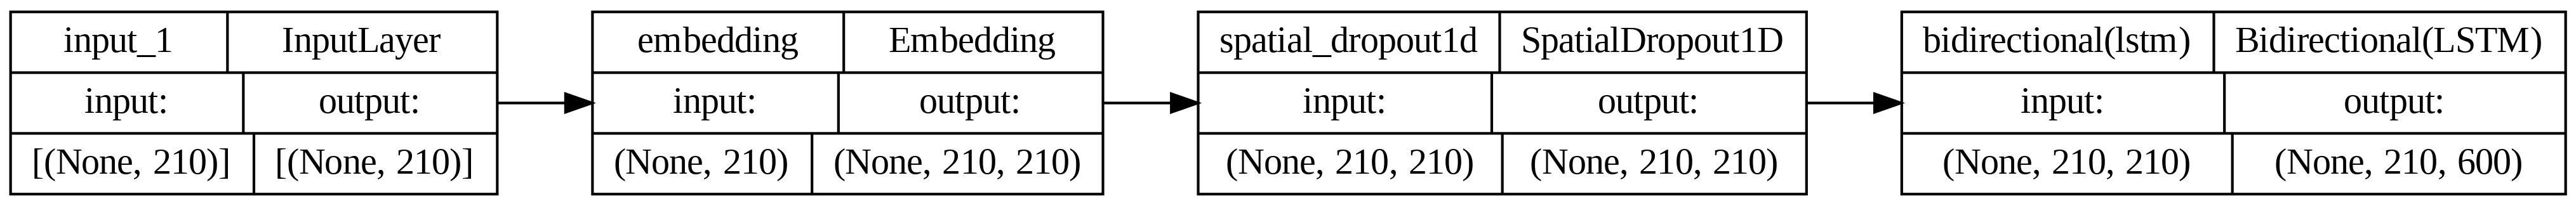

In [63]:
tf.keras.utils.plot_model(
    model, to_file='resources/model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='LR', expand_nested=True, dpi=300,
)

In [64]:
logdir = 'logs/'
tensorboard_callback = TensorBoard(log_dir=logdir)

model_checkpoint = ModelCheckpoint('resources/model.keras', monitor='val_loss', verbose=1, save_best_only=True,
                                   save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=1, mode='max', baseline=None)
plot_losses = PlotLossesCallback()

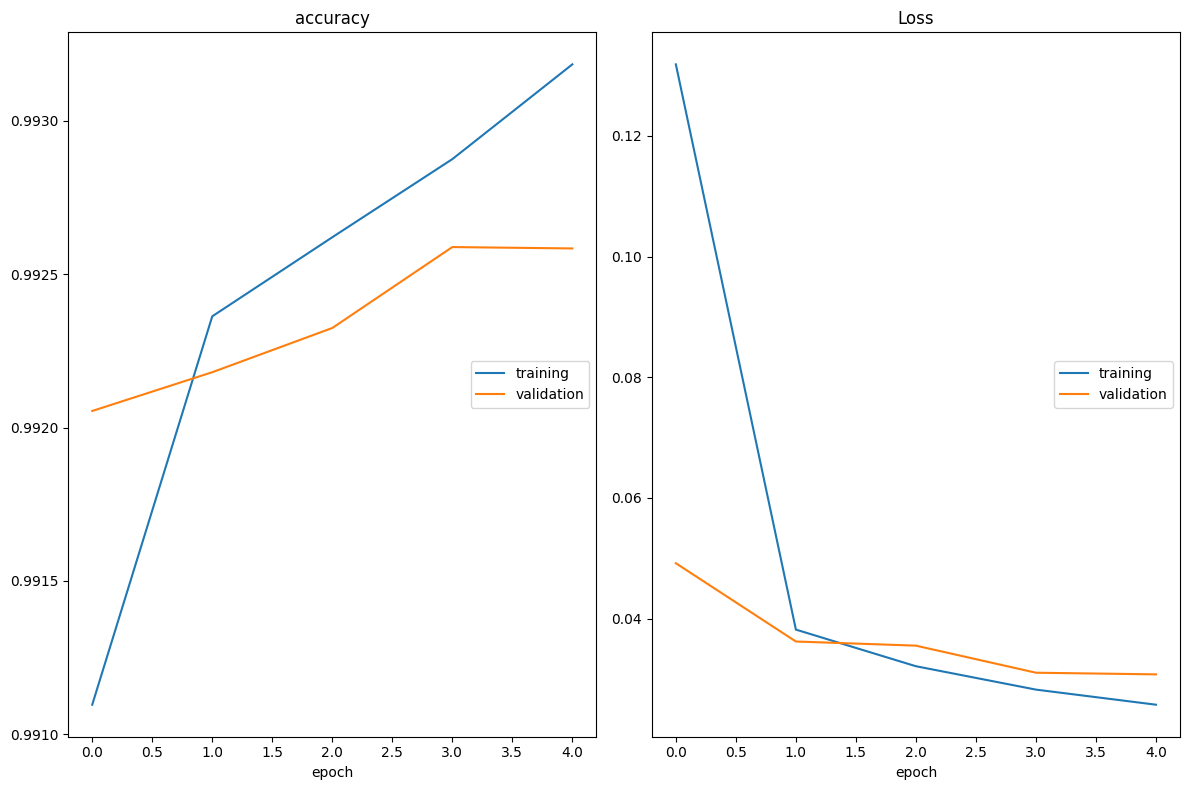

accuracy
	training         	 (min:    0.991, max:    0.993, cur:    0.993)
	validation       	 (min:    0.992, max:    0.993, cur:    0.993)
Loss
	training         	 (min:    0.026, max:    0.132, cur:    0.026)
	validation       	 (min:    0.031, max:    0.049, cur:    0.031)
538/538 [==============================] - 26s 49ms/step - loss: 0.0257 - accuracy: 0.9932 - val_loss: 0.0308 - val_accuracy: 0.9926
Epoch 5: early stopping


In [66]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=20, verbose=1,
                    callbacks=[tensorboard_callback, model_checkpoint, early_stopping, plot_losses])

In [67]:
# model.save('resources/model.keras')
# model = tf.keras.models.load_model('resources/model.keras')

## Evaluation

In [68]:
def pred_y(x):
    p = model.predict(np.array([x]))
    p = np.argmax(p, axis=-1)
    return p

def print_prediction(x, y):
    print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
    print("-" *30)
    for w, true, pred in zip(x, y, pred_y(x)):
        try:
            print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))
        except IndexError:
            print("{:15}{}\t{}".format(words[w-1], tags[true], 'O'))

In [73]:
sample_X = 'من پارسال موقع عید کتاب جز از کل رو از انتشارات چشمه خوندم باید بگم که موقع خوندنش واقعاً محو قلم استیو تولتز شده بودم.'
sample_X = higher_preprocess(elementary_preprocess(sample_X))
sample_X = [[word2idx[word] if word in word2idx else -1 for word in sample_X]]
sample_X = pad_sequences(sample_X, maxlen=max_length, padding='post', value=words_size-1)

p = pred_y(sample_X[0])
print("{:15}\t {}\n".format("Word", "Pred"))
print("-" *30)
for w, pred in zip(sample_X[0], p[0]):
    try:
        print("{:15}\t{}".format(words[w], tags[pred]))
    except IndexError:
        print("{:15}\t{}".format(words[w], 'O'))

1/1 [==============================] - 0s 40ms/step
Word           	 Pred

------------------------------
من             	O
پارسال         	O
موقع           	O
عید            	O
کتاب           	O
جز             	O
از             	O
کل             	O
رو             	O
از             	O
انتشارات       	B-Publisher
چشمه           	O
خوندم          	O
باید           	O
بگم            	O
که             	O
موقع           	O
خوندنش         	O
واقعا          	O
محو            	O
قلم            	O
استیو          	B-Book
تولتز          	O
شده_بودم       	O
STARTPAD       	O
STARTPAD       	O
STARTPAD       	O
STARTPAD       	O
STARTPAD       	O
STARTPAD       	O
STARTPAD       	O
STARTPAD       	O
STARTPAD       	O
STARTPAD       	O
STARTPAD       	O
STARTPAD       	O
STARTPAD       	O
STARTPAD       	O
STARTPAD       	O
STARTPAD       	O
STARTPAD       	O
STARTPAD       	O
STARTPAD       	O
STARTPAD       	O
STARTPAD       	O
STARTPAD       	O
STARTPAD       	O
STARTPAD       	O
STARTPAD       

In [79]:
i = np.random.randint(0, X_test.shape[0])
print("This is sentence:",i)
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)

print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(X_test[i], y_test[i], p[0]):
    try:
        print("{:15}{}\t{}".format(words[w], tags[true], tags[pred]))
    except IndexError:
        print("{:15}{}\t{}".format(words[w], tags[true], 'O'))

This is sentence: 517
1/1 [==============================] - 0s 22ms/step
Word           True 	 Pred

------------------------------
یک             O	O
ستاره          O	O
هم             O	O
اجباری         O	O
بود            O	O
وگرنه          O	O
مفت            O	O
هم             O	O
گرونه          O	O
چرت‌تر         O	O
از             B-Book	O
این            O	O
کتاب           O	O
نبود           O	O
رایگان         O	O
کنید           O	O
کتاب‌های       O	O
رایگان         O	O
تون            O	O
آخره           O	O
بی             O	O
انصافیه        O	O
STARTPAD       O	O
STARTPAD       O	O
STARTPAD       O	O
STARTPAD       O	O
STARTPAD       O	O
STARTPAD       O	O
STARTPAD       O	O
STARTPAD       O	O
STARTPAD       O	O
STARTPAD       O	O
STARTPAD       O	O
STARTPAD       O	O
STARTPAD       O	O
STARTPAD       O	O
STARTPAD       O	O
STARTPAD       O	O
STARTPAD       O	O
STARTPAD       O	O
STARTPAD       O	O
STARTPAD       O	O
STARTPAD       O	O
STARTPAD       O	O
STARTPAD       O	O
STARTPA

In [75]:
y_pred = model.predict(X_test)

68/68 [==============================] - 1s 13ms/step


In [76]:
y_pred_index = np.argmax(y_pred, axis=-1)

X_test_list = X_test.tolist()
y_test_list = y_test.tolist()
y_pred_list = y_pred_index.tolist()

start_pad_index = word2idx['STARTPAD']
# progress_bar = tqdm(range(len(X_test)))
for i in range(len(X_test_list)):
    x_start_pad = X_test_list[i].index(start_pad_index)
    X_test_list[i] = X_test_list[i][:x_start_pad]
    y_test_list[i] = y_test_list[i][:x_start_pad]

    y_pred_list[i] = y_pred_list[i][:x_start_pad]
    y_pred_list[i] = [tag if tag <= 8 else 8 for tag in y_pred_list[i]]


y_test_flatten = []
for y in y_test_list:
    y_test_flatten.extend(y)

y_pred_flatten = []
for y in y_pred_list:
    y_pred_flatten.extend(y)

print(classification_report(y_test_flatten, y_pred_flatten))

              precision    recall  f1-score   support

           0       0.65      0.64      0.65       442
           1       0.50      0.11      0.18      2033
           2       0.53      0.18      0.27       483
           3       0.00      0.00      0.00        40
           4       0.50      0.28      0.36       155
           5       0.39      0.15      0.22       319
           6       0.00      0.00      0.00        42
           7       0.00      0.00      0.00        12
           8       0.97      0.99      0.98     76751

    accuracy                           0.96     80277
   macro avg       0.39      0.26      0.29     80277
weighted avg       0.95      0.96      0.95     80277



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



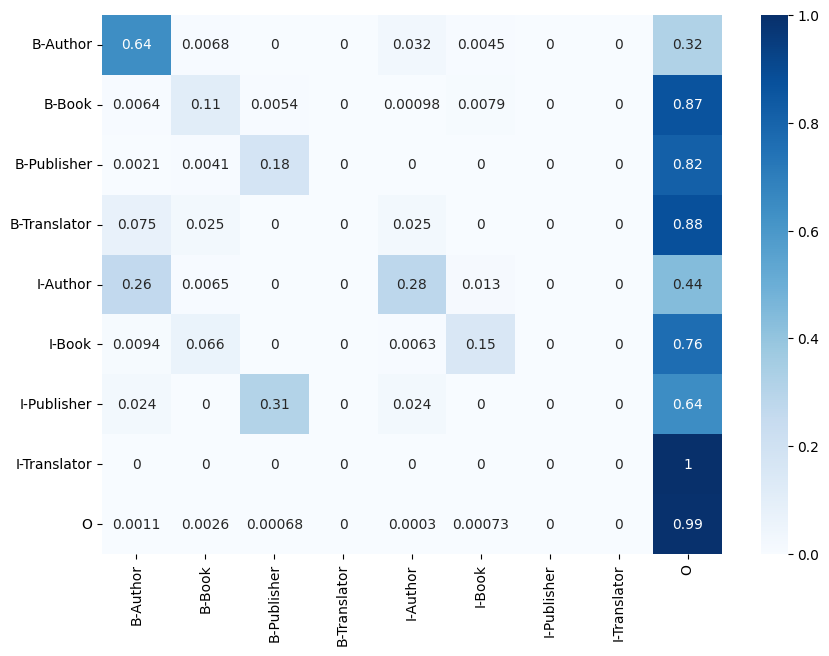

In [77]:
cm = confusion_matrix(y_test_flatten, y_pred_flatten)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, xticklabels=tags, yticklabels=tags, cmap='Blues')
plt.show()

In [78]:
print('Accuracy:', accuracy_score(y_test_flatten, y_pred_flatten))
print()
print('Micro Precision:', precision_score(y_test_flatten, y_pred_flatten, average='micro'))
print('Macro Precision:', precision_score(y_test_flatten, y_pred_flatten, average='macro'))
print('Weighted Precision:', precision_score(y_test_flatten, y_pred_flatten, average='weighted'))
print()
print('Micro Recall:', recall_score(y_test_flatten, y_pred_flatten, average='micro'))
print('Macro Recall:', recall_score(y_test_flatten, y_pred_flatten, average='macro'))
print('Weighted Recall:', recall_score(y_test_flatten, y_pred_flatten, average='weighted'))
print()
print('Micro F1-score:', f1_score(y_test_flatten, y_pred_flatten, average='micro'))
print('Macro F1-score:', f1_score(y_test_flatten, y_pred_flatten, average='macro'))
print('Weighted F1-score:', f1_score(y_test_flatten, y_pred_flatten, average='weighted'))

Accuracy: 0.9594279806171132

Micro Precision: 0.9594279806171132
Macro Precision: 0.3934900376200633
Weighted Precision: 0.9455743349730555



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Micro Recall: 0.9594279806171132
Macro Recall: 0.26183398222539545
Weighted Recall: 0.9594279806171132

Micro F1-score: 0.9594279806171132
Macro F1-score: 0.2949953149539064
Weighted F1-score: 0.9484172831756426
